# Aerial Cactus Identification

> To assess the impact of climate change on Earth's flora and fauna, it is vital to quantify how human activities such as logging, mining, and agriculture are impacting our protected natural areas. Researchers in Mexico have created the VIGIA project, which aims to build a system for autonomous surveillance of protected areas. A first step in such an effort is the ability to recognize the vegetation inside the protected areas

In this competition,we need to create an algorithm that can identify a specific type of cactus (Columnar Cactus) in aerial imagery.

We have small size 32*32 images which is used to train a model and test against the validation and test data to accurately classify the cactus

## Initialize library
> The fastai library simplifies training fast and accurate neural nets using modern best practices. It's based on research in to deep learning best practices undertaken at fast.ai, including "out of the box" support for vision, text, tabular, and collab (collaborative filtering) models

 Here we are going to use fastai vision library with various pretained model ensemble to classify the aerial cactus images into cactus and non-cactus

In [ ]:
import time
start = time.time()

import numpy as np
import pandas as pd

from fastai.vision import *
from fastai.callbacks import *

from pathlib import Path

import os
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
import PIL

np.random.seed(10)

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [ ]:
# Create Training and Test dataframe from input data 
data_folder = Path("../input")
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/sample_submission.csv")

## Data Exploration 

Taking reference from the Kernel 

https://www.kaggle.com/benjaminwarner/aerial-cactus-prediction-using-fast-ai-resnet-34

Here we can understand that there is a class imbalance between cactus and non cactus images . Therefore copying the non-cactus data multiple time in the training dataset so that the dataset becomes almost equal between cactus and non-cactus records to create oversampling

In [ ]:
df1 = train_df[train_df.has_cactus==0].copy()
df2 = df1.copy()
train_df = train_df.append([df1, df2], ignore_index=True)

Below are the comparison of data after the oversampling 

In [ ]:
sns.countplot('has_cactus', data=train_df)
plt.title('Classes', fontsize=15)
plt.show()

## Create Transformation and DataBunch
Using Fastai now we are creating transformation . Refer the optimum transformation paramters in the below Kernel .I have added only contrasts into the transformation

https://www.kaggle.com/kenseitrg/simple-fastai-exercise



In [ ]:
test_img = ImageList.from_df(test_df, path=data_folder/'test', folder='test')

trfm = get_transforms(do_flip=True, flip_vert=True, max_rotate=10.0, max_zoom=1.1,
                      max_lighting=0.2, max_warp=0.2, 
                      p_affine=0.75, p_lighting=0.75 ,xtra_tfms=[contrast(scale=(0.5, 1), p=0.75)])
#trfm1 = get_transforms(do_flip=True, flip_vert=True)
imagesize = 64
batchsize = 64
### Created the function train data as I wanted to vary the image sizes while training and it will give some flexibility 
### in creating data 
def train_data (imagesize,batchsize) : 
    train_img = (ImageList.from_df(train_df, path=data_folder/'train', folder='train')
        .split_by_rand_pct(0.2,seed =344) ##20% of the data is used as validation
        .label_from_df()
        .add_test(test_img)
        .transform(trfm, size=imagesize)
        .databunch(path='.', bs=batchsize, device= torch.device('cuda:0'))
        .normalize(imagenet_stats)
       )
    return train_img

In [ ]:
data = train_data(imagesize,batchsize)

### Lets see how the training data sample looks like.

In [ ]:
train_img1 = train_data(64,64)


In [ ]:
train_img1.show_batch(rows=5, figsize=(10,10))


### Ensembling of fastai pretrained models. 

I have taken  major reference from the below blog which I felt is very informative . Some of the functions are probably not compatible with the version I have and hence direct adoption will not work . Also , I have not done freezing and unfreeing of layers in this version. As it was taking much time without great benefit.
https://towardsdatascience.com/kaggle-planet-competition-how-to-land-in-top-4-a679ff0013ba
https://towardsdatascience.com/ensembling-convnets-using-keras-237d429157eb

## Ensembling :

There are many different types of ensembles;
e.g 
1. Simple Averaging
2. Bagging
3. Boosting

 Stacking involves training a learning algorithm to combine the predictions of several other learning algorithms. For the sake of this example, I will use one of the simplest forms of Stacking, which involves taking an average of outputs of models in the ensemble. Since averaging doesn’t take any parameters, there is no need to train this ensemble (only its models).
 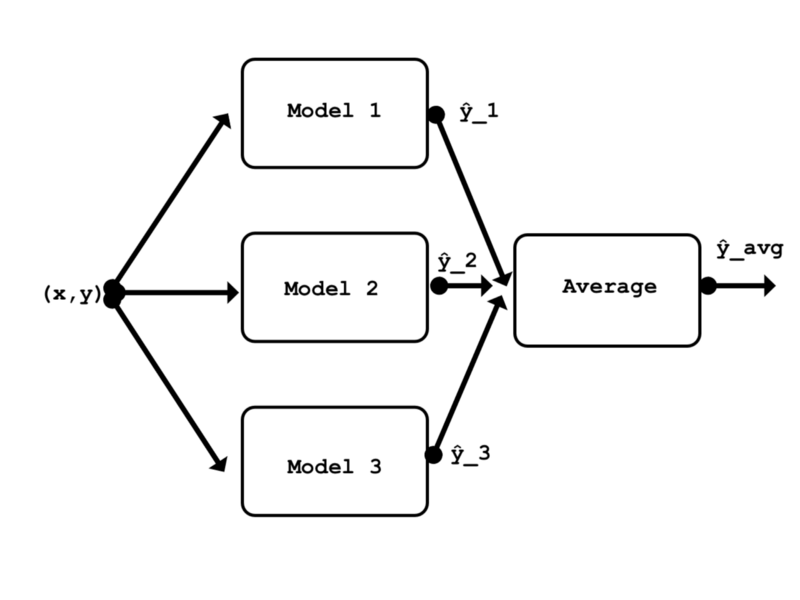
 
 
 ### Model1 = densenet161
 ### Model2 = densenet161
 ### Model3 = densenet201

In [ ]:
nmodels = 3

In [ ]:
def get_ensemble(nmodels):
    ens_model = [] # Empty List of ensemble model, I will store the trained learner object here 
    learning_rate =[2.95e-02,3e-02,3e-02] # List of learning rate for each model 
    model_list = [models.densenet161,models.densenet161,models.densenet201] ##List of Models . You can add resnet ones in the mix
    for i in range(nmodels):
        print(f'-----Training model: {i+1}--------')
             
        data = train_data(64,64)
        learn_resnet = cnn_learner(data, model_list[i], metrics=[error_rate, accuracy,AUROC()],
                                   model_dir="/tmp/model/")

        print('training for 128x128')
        learn_resnet.set_data = train_data(128,64) # Train the model for imagesize 128
        learn_resnet.lr_find()
        learn_resnet.recorder.plot(suggestion=True)
        learn_resnet.fit_one_cycle(3,slice(learning_rate[i])) # using the learning rate for the first model 
        
        print('training for 150x150')
        learn_resnet.set_data = train_data(150,96) #Train the model for imagesize 150
        learn_resnet.fit_one_cycle(3,slice(learning_rate[i]))   # using the learning rate assigned for the first model   
        
        learn_resnet.save(f'ensem_model_{i}.weights')
        ens_model.append(learn_resnet)
        print(f'-----Training of model {i+1} complete----')
    return ens_model

In [ ]:
ens = get_ensemble(3) # ens is a list type of object which will contain my three learnt model

In [ ]:
end = time.time()
print(end - start) ## This is to calculate training time to keep me sane.

## Model Prediction
Now since the model is trained , we are going to call Test Time Augmentation function of Fastai to get a prediction of test dataset 
### What is Test Time Augmentation ?
Similar to what Data Augmentation is doing to the training set, the purpose of Test Time Augmentation is to perform random modifications to the test images. Thus, instead of showing the regular, “clean” images, only once to the trained model, we will show it the augmented images several times. We will then average the predictions of each corresponding image and take that as our final guess.

In [ ]:
#Prepare test predictions
ens_test_preds = [] ## Creating a list of predictions 
for mdl in ens:
    preds,_ = mdl.TTA(ds_type=DatasetType.Test)
    print(np.array(preds).shape)
    ens_test_preds.append(np.array(preds)) ## create a list of prediction numpy arrays . 

In [ ]:
ens_preds = np.mean(ens_test_preds, axis =0) ## Average the prediction from various numpy arrays using numpy mean function

In [ ]:
ens_preds.shape

In [ ]:
test_df.has_cactus = ens_preds[:, 0] ##update the prediction in the test data
test_df.head()


In [ ]:
test_df.to_csv('submission.csv', index=False)

## Confusion Matrix
Let us create the confusion matrix using the out of the box functions . We are passing the individual trained models from the list to see how it fares

A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.

This is how a confusion matrix looks like .

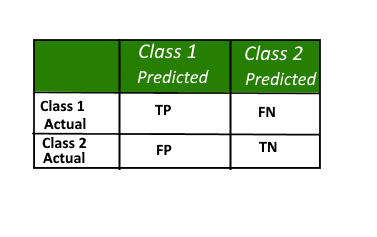

#### Terms :
• Positive (P) : Observation is positive (for example: is a cactus).
• Negative (N) : Observation is not positive (for example: is not a cactus).
• True Positive (TP) : Observation is positive, and is predicted to be positive.
• False Negative (FN) : Observation is positive, but is predicted negative.
• True Negative (TN) : Observation is negative, and is predicted to be negative.
• False Positive (FP) : Observation is negative, but is predicted positive.


In [ ]:
interp = ClassificationInterpretation.from_learner(ens[0])
interp1 = ClassificationInterpretation.from_learner(ens[1])
interp2 = ClassificationInterpretation.from_learner(ens[2])


In [ ]:
interp.plot_confusion_matrix()
interp1.plot_confusion_matrix()
interp2.plot_confusion_matrix()

### Why it does , what it does

We can plot top losses from the learner and also keep the heatmap true to bring in a little explainability into the prediction as to where the convnet looked through the layer and how it predicted , what it predicted 

In [ ]:
interp.plot_top_losses(6, figsize=(10,10),heatmap = True)
interp1.plot_top_losses(6, figsize=(10,10),heatmap = False)
interp2.plot_top_losses(6, figsize=(10,10),heatmap = False)

